In [1]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng()

from scipy.optimize import curve_fit

# to integrate
import scipy.integrate as integrate
import scipy.special as special
from scipy.integrate import quad

import warnings
warnings.filterwarnings('ignore')

Some constants.
1. muon mass
https://physics.nist.gov/cgi-bin/cuu/Value?mmu
2. elementary charge
https://physics.nist.gov/cgi-bin/cuu/Value?e
3. magnetic field used the one from source 2

$$ \omega = \frac{geB}{2M_{μ}}$$

$$ g= \frac{2 \omega M_{\mu}}{eB} $$

$$ \Delta g = \sqrt{(\frac{\Delta\omega}{\omega})^2 + (\frac{\Delta M_{\mu}}{M_{\mu}})^2 + (\frac{\Delta e}{e})^2 + (\frac{\Delta B}{B})^2} $$

Which simplifies if we let the uncertainty in $e$ be 0.

$$ \Delta g = \sqrt{(\frac{\Delta\omega}{\omega})^2 + (\frac{\Delta M_{\mu}}{M_{\mu}})^2 + (\frac{\Delta B}{B})^2} $$

The only things that we will vary or investigate are $\omega$ or $B$.

In [2]:
muon_mass= 1.883531627e-28
muon_mass_unc = 0.000000042e-28

e_charge = 1.602176634e-19
e_unc = 0

B = 5.5e-3   # 5.5 Gauss is 5.5e-3 tesla
B_unc = 0.11e-3 # Homogeneity of 4% of the magnetic field so set the error bar size to 2% of the total magnetic field

Detector parameters

In [3]:
# Detector parameters
# Length of detector = 2*L
L = 2.5

# Detector target height
H = 1

In [4]:
def muon_generator(n):
    """
    Inputs: n monte carlo generations
    outputs: muon data in format [position, theta, spin, probability] and amount of muons
    
    """

    global L
    global H

    # theta values
    thetaArray = (np.pi/2)*rng.uniform(-1,1,size=(n,1))

    # y values
    yArray = rng.uniform(0,1,size=(n,1))

    # combining them
    coords = np.hstack((thetaArray,yArray))
    
    # Delete generations that do not fit distribution
    muon_filter = np.delete(coords, np.where(coords[:,1] > np.cos(coords[:,0])**2),axis = 0)
    
    # create an array of allowed theta values
    muontheta = muon_filter[:,0]
    
    # Uniform distribution of muon position on detector between -2.5 to 2.5
    muon_posn = rng.uniform(-L,L,size=(len(muontheta),1))

    # Reshape muontheta into shape that can be stacked
    muon_theta = np.reshape(muontheta,(len(muontheta),1))

    # Generate positron emission distribution
    a = 0.3
    emissionthetaArray = np.pi*rng.uniform(-1,1,size=(n,1)) #np.pi/2.7*rng.uniform(-1,1,size=(n,1))
    yemissionArray = rng.uniform(0,1+a,size=(n,1))
    emissioncoords = np.hstack((emissionthetaArray,yemissionArray))
    emissionfilter = np.delete(emissioncoords, np.where(emissioncoords[:,1] > (1+ a*np.cos(emissioncoords[:,0]))),axis=0)
    emissionmuons = emissionfilter[:,0]
    hi = emissionmuons[:len(muontheta)]
    
    muon_emission = np.reshape(hi,(len(muontheta),1))
    
    # Generate muon probability of stopping at copper
    # Replace this line with muon momentum distribution
    muon_stop_p = rng.random(size=(len(muontheta),1))
    
    # Positron emission theta
    positron_emission = muon_emission + muon_theta

    # Stack all the data together to get muons
    muons = np.hstack((muon_posn,muon_theta,muon_emission,muon_stop_p,positron_emission))
    
    return muons, len(muons)

def caught_muons_2D(muons):
    """
    Function output array of caught muons in the detector in a 2D description in the format
    [pos,theta,spin,p]
    
    Input: muons array
    """
    # Muons that hit target
    muons_target = np.delete(muons, np.where(np.abs(muons[:,0]+H*np.tan(muons[:,1]))>=L), axis=0)
    
    # Muons that stops at the target
    muons_stopped = np.delete(muons_target, np.where(muons_target[:,3]>0.3),axis=0)
    
    # Moves the muons to the correct position on the detector
    muons_stopped[:,0] = muons_stopped[:,0] + H*np.tan(muons_stopped[:,1])
    return muons_stopped

def simulator(n,B,dt):
    """
    
    """

    global g
    global e
    global m
    global tau

    muons , amount = muon_generator(n)
    caught_muons = caught_muons_2D(muons)

    # omega
    omega = g*e*B/(2*m) # Hz

    # Decay time from 0 to 10 microseconds
    #time = np.arange(0,10,dt)
    #time = np.arange(0+dt,10+dt,dt) # start from first dt
    time = np.arange(0+dt/2,10+dt/2,dt) # start from dt/2 

    # Creating array for number of detected positrons
    N = np.zeros((len(time),2))

    for i in range(len(time)):
        # Precession, omgea*dt, dt converted to seconds
        prec = omega*(dt*10**(-6))
        
        # Adding precession to muon theta 
        caught_muons[:,1] += prec
        caught_muons[:,4] += prec
        
        # Generating random number between 0 and 1
        p = rng.random(size=len(caught_muons))
        
        # Replace 4th data column of the muons, previously was p 
        # p previously was the random number for muon stopping in copper
        caught_muons[:,3] = p
        
        # Probability of decay
        decay_prob = 1-np.exp(-dt/tau)
        
        # Collect the rows where muon decays
        decayed_muons = caught_muons[np.where(caught_muons[:,3]<decay_prob)[0]]
        
        # Delete decayed muons from the caught muons array
        caught_muons = np.delete(caught_muons,np.where(caught_muons[:,3]<decay_prob),axis=0)
        
        # Delete muons whose positron will not be captured by detector 
        # Or Delete muons whose positron emitted away from the detector
        detected_positrons = np.delete(decayed_muons, np.where( (np.abs(decayed_muons[:,0]+H*np.tan(decayed_muons[:,4]))>=L) | (np.cos(decayed_muons[:,4])<0)),axis=0) 
        
        # Count the number of detected positrons and add it to the list
        N[i] = [len(detected_positrons),time[i]]   

    return N

## Global parameters
- g
- e
- m
- tau

In [5]:
g = 2 # https://physics.nist.gov/cgi-bin/cuu/Value?gmum|search_for=muon
e = 1.6*10**(-19) # J
m = 1.883*10**(-28) # kg
tau = 2.2 # microseconds

## First test
With:
- n = 1000000
- B = 0.0055
- dt = 0.05

Text(0, 0.5, 'Detected positrons')

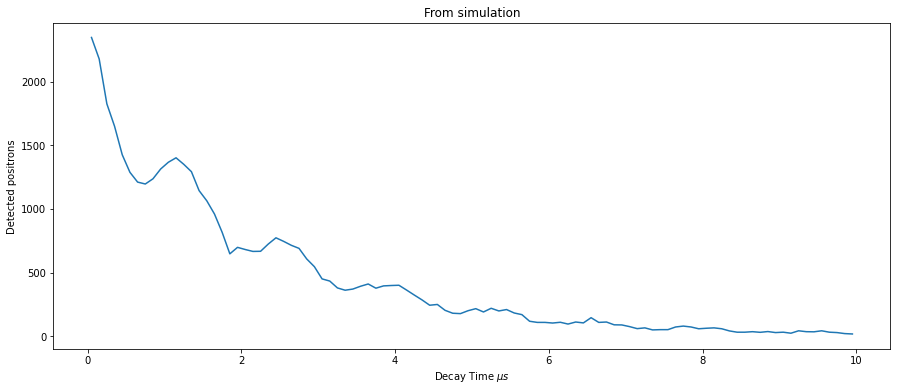

In [6]:
# n , B , dt
dt=0.1
test1 = simulator(1000000,0.0055,dt)

plt.figure(figsize=(15,6))
plt.plot(test1[:,1],test1[:,0])

plt.title("From simulation")
plt.xlabel(r"Decay Time $\mu s$")
plt.ylabel("Detected positrons")


In [7]:
## corrected our function to match citation 2 where the decay factor for both components is the same, i.e b = f in our function
def func(x, a, b, c, d, w, phi):
  """Function of the counts of different decay times"""
  return a * np.exp(-b * x) + c + d * np.exp(-b*x)*np.sin(w*x + phi)

def simulator_calculate(n, B, dt):
  # Run simulation
  test = simulator(n, B, dt)

  # Save variables appropriately and get parameters and parameter errors
  test_x64 = np.array(test[:,1], dtype=np.float64)
  test_y64 = np.array(test[:,0], dtype=np.float64)
  count_tot = np.int(np.sum(test_y64))
  popt, pcov = curve_fit(func, test_x64, test_y64, p0=[1,1,1,1,4.57,np.pi/2])
  print("Parameters are", popt)
  Perr = np.sqrt(np.diag(pcov))  
  print("Error in parameters are", Perr)

  # Get error bars
  Errors_array = np.zeros(np.shape(test_x64))
  for count, i in enumerate(test_x64):
    Errors_array[count] =  np.absolute(test_y64[count]-func(i,*popt))/np.sqrt(test_y64[count])

  # Correct for background error in quadruature 
  Errors_array = np.sqrt(Errors_array**2 + Perr[2]**2)
  return test_x64, test_y64, count_tot, popt, pcov, Perr, Errors_array

def plot():
  # Plot the original data and plot our function with our fitted parameters *popt
  x_array = np.linspace(0,10,150)
  plt.figure(figsize=(11,8))
  plt.errorbar(test_x64, test_y64, yerr= Errors_array, label = "Generated data \n n = {} \n dt = {}" .format(count_tot, dt), ecolor='green', fmt="x", capsize=2)
  plt.plot(x_array, func(x_array, *popt), 'r--', label = "Fitting curve")
  plt.legend(fontsize="x-large")


  plt.xlabel(r"Decay Time ($\mu s$)")
  plt.ylabel("Detected Positrons")

  # Visual stuff for the plot
  plt.xlim(xmin=0,xmax=10+dt); 
  plt.xticks(ticks=np.linspace(0,10,11));

def lande_g():
  ## Now we calculate the lande g factor
  w = popt[4]*10**6 # in MHz convert to Hz
  w_err = Perr[4]

  g_lande = 2*w*muon_mass/(e_charge*B)
  print("Our g lande factor is:", g_lande)

  g_lande_err = 2*g_lande* np.sqrt((w_err/w)**2 + (muon_mass_unc/muon_mass)**2 + (B_unc/B)**2)
  print("Our g lande factor error is:", g_lande_err)

  print("w is:", w)
  print("w_err is:", w_err)
  return w, w_err, g_lande, g_lande_err

def lande_g_err():
  ## Uses poison error
  ## Now we calculate the lande g factor using our own errors, see sigma=Errors_array
  popt, pcov = curve_fit(func, test_x64, test_y64, p0=[1,1,1,1,4.57,np.pi/2],sigma=Errors_array)
  w = popt[4]*10**6 # in MHz convert to Hz
  w_err = Perr[4]

  g_lande = 2*w*muon_mass/(e_charge*B)
  print("Our g lande factor is:", g_lande)

  g_lande_err = 2*g_lande* np.sqrt((w_err/w)**2 + (muon_mass_unc/muon_mass)**2 + (B_unc/B)**2)
  print("Our g lande factor error is:", g_lande_err)
  return w, w_err, g_lande, g_lande_err

Parameters are [ 1.63024397e+03  4.58095470e-01 -3.18143037e-01  2.63381923e+02
  4.61782569e+00  2.14604382e+00]
Error in parameters are [1.37334015e+01 8.19588434e-03 5.91553526e+00 1.30856150e+01
 4.27625738e-02 6.89932945e-02]
Our g lande factor is: 1.9740918926599267
Our g lande factor error is: 0.07896367570645461
w is: 4617825.690175451
w_err is: 0.04276257375224578
Start
Parameters are [160.8110579    0.4338845   -1.02659952  26.59061895   4.79235965
   1.92689154]
Error in parameters are [2.58895064 0.01547984 1.23552218 2.43464355 0.07873751 0.13546536]
Our g lande factor is: 2.048704079227747
Our g lande factor error is: 0.08194816316918846
w is: 4792359.648404112
w_err is: 0.07873750697020321
Parameters are [16.343941    0.47330284  0.04447195  3.5052612   6.386562    8.38650154]
Error in parameters are [1.20916424 0.07440854 0.52223338 1.2248435  0.30169919 0.45709489]
Our g lande factor is: 2.7302157151929207
Our g lande factor error is: 0.10920862860808934
w is: 6386562.

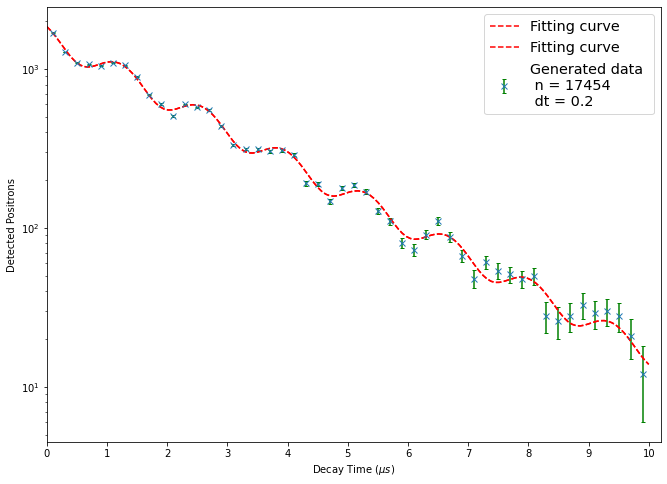

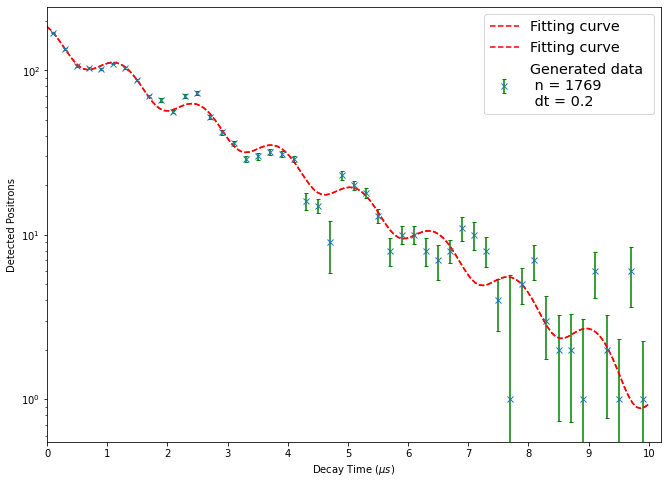

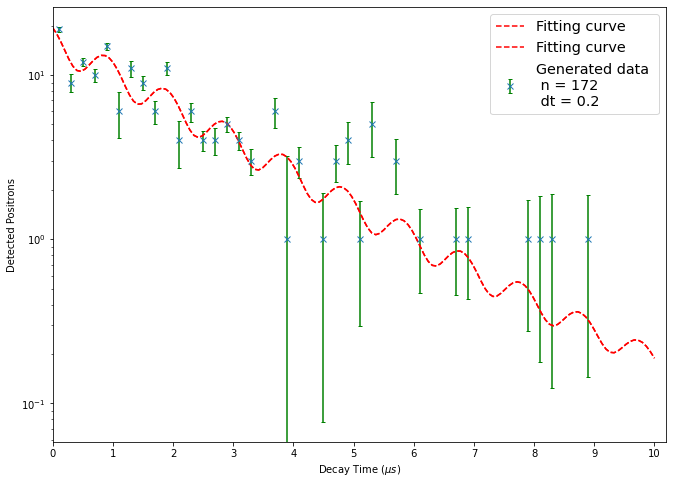

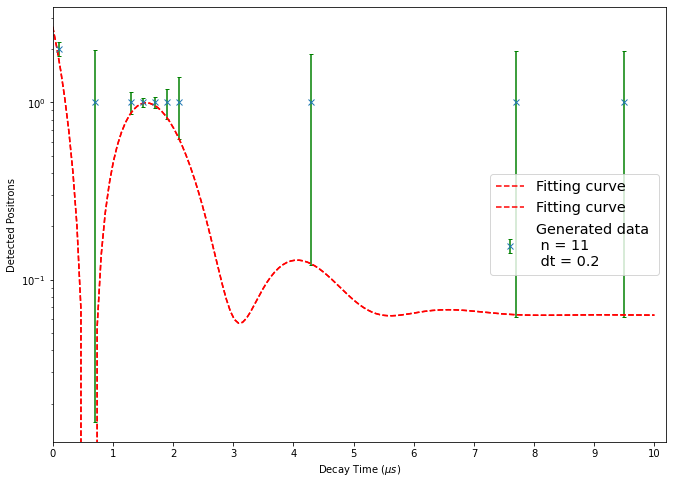

In [8]:
dt = 0.2
test_x64, test_y64, count_tot, popt, pcov, Perr, Errors_array = simulator_calculate(400000, B, dt)
plot()
plt.yscale("log",base = 10) # optionally set to log scale 

# Find the lande_g factor 
w, w_err, g_lande, g_lande_err = lande_g()
# print("w is:", w)
# print("w_err is:", w_err)


## test varying number of events
print("Start")
test_x64, test_y64, count_tot, popt, pcov, Perr, Errors_array = simulator_calculate(40000, B, dt)
plot()
plt.yscale("log",base = 10) # optionally set to log scale 

# Find the lande_g factor 
w, w_err, g_lande, g_lande_err = lande_g()

## test varying number of events
test_x64, test_y64, count_tot, popt, pcov, Perr, Errors_array = simulator_calculate(4000, B, dt)
plot()
plt.yscale("log",base = 10) # optionally set to log scale 

# Find the lande_g factor 
w, w_err, g_lande, g_lande_err = lande_g()

## test varying number of events
test_x64, test_y64, count_tot, popt, pcov, Perr, Errors_array = simulator_calculate(400, B, dt)
plot()
plt.yscale("log",base = 10) # optionally set to log scale 
print(count_tot)

# Find the lande_g factor 
w, w_err, g_lande, g_lande_err = lande_g()

## Get a plot that represents a realistic setup i.e replicating source 2 

(https://aapt.scitation.org/doi/10.1119/1.1987938)


Parameters are [4.06483777e+03 4.54515097e-01 1.23904721e+00 7.88214638e+02
 4.71508082e+00 1.98014432e+00]
Error in parameters are [1.98417864e+01 4.68161901e-03 8.62593726e+00 1.87294824e+01
 2.09865731e-02 3.46166201e-02]
[0.11906158 1.06173415 0.63160337 0.81204817 0.55285065 0.02503297
 0.62008714 1.0517342  0.0625018  0.17798825 0.94927602 1.41706396
 0.30315589 0.31692566 0.25954549 0.44108494 0.64762448 1.58981848
 0.57421726 0.08537322 3.23110386 0.84357281 0.10984392 1.33013235
 0.35891905 2.727031   1.03610216 0.69066388 0.83659145 1.36447041
 0.02907773 1.27663373 0.02947365 1.27881003 0.19735207 0.74085218
 0.27036932 0.14445784 0.90550112 0.62469749 0.81330721 0.7315286
 2.89404239 0.9911866  0.24682621 2.22962235 0.95448873 0.62226628
 0.05222093 0.21530477]


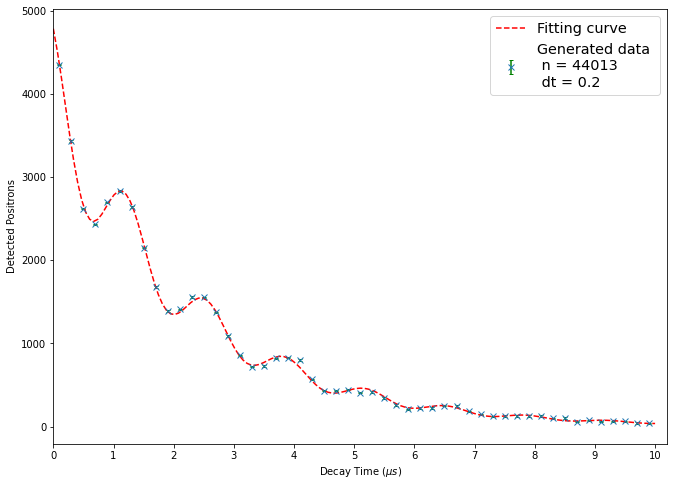

In [9]:
# Run the simulation
dt=0.2 # time resolution 
test2 = simulator(1000000,0.0055,dt)

# Save variables appropriately and get parameters and parameter errors
test2_x64 = np.array(test2[:,1], dtype=np.float64)
test2_y64 = np.array(test2[:,0], dtype=np.float64)
count_tot2 = np.int(np.sum(test2_y64))
popt, pcov = curve_fit(func, test2_x64, test2_y64, p0=[1,1,1,1,4.57,np.pi/2])
print("Parameters are", popt)
Perr = np.sqrt(np.diag(pcov))  
print("Error in parameters are", Perr)

## Get error bars
Errors_array2 = np.zeros(np.shape(test2_x64))
for count, i in enumerate(test2_x64):
  Errors_array2[count] =  np.absolute(test2_y64[count]-func(i,*popt))/np.sqrt(test2_y64[count])

print(Errors_array2)

# correct for background error in quadruature 
Errors_array2 = np.sqrt(Errors_array2**2 + Perr[2]**2)

# Plot the original data and plot our function with our fitted parameters *popt
x_array = np.linspace(0,10,150)
plt.figure(figsize=(11,8))
plt.errorbar(test2_x64, test2_y64, yerr= Errors_array2, label = "Generated data \n n = {} \n dt = {}" .format(count_tot2, dt), ecolor='green', fmt="x", capsize=2)
#plt.yscale("log",base = 10)
plt.plot(x_array, func(x_array, *popt), 'r--', label = "Fitting curve")
plt.legend(fontsize="x-large")


plt.xlabel(r"Decay Time ($\mu s$)")
plt.ylabel("Detected Positrons")

# Visual stuff for the plot
plt.xlim(xmin=0,xmax=10+dt); 
plt.xticks(ticks=np.linspace(0,10,11));

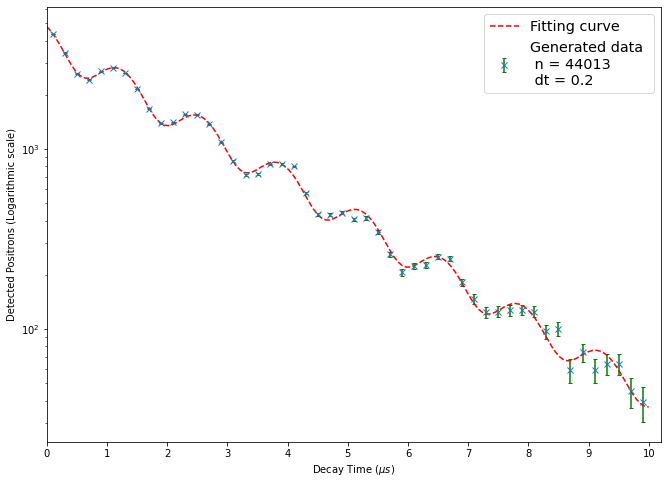

In [10]:
# Plot the original data and plot our function with our fitted parameters *popt
x_array = np.linspace(0,10,150)
plt.figure(figsize=(11,8))
plt.errorbar(test2_x64, test2_y64, yerr= Errors_array2, label = "Generated data \n n = {} \n dt = {}" .format(count_tot2, dt), ecolor='green', fmt="x", capsize=2)
plt.yscale("log",base = 10)
plt.plot(x_array, func(x_array, *popt), 'r--', label = "Fitting curve")
plt.legend(fontsize="x-large")

plt.xlabel(r"Decay Time ($\mu s$)")
plt.ylabel("Detected Positrons (Logarithmic scale)")

# Visual stuff for the plot
plt.xlim(xmin=0,xmax=10+dt) ; 
plt.xticks(ticks=np.linspace(0,10,11));


## Get a plot that represents a realistic setup i.e TeachSpin specs
https://www.teachspin.com/muon-physics

Bin size of 20 nanoseconds, 1 event/minute. 

Parameters are [403.49753366   0.45007168  -0.45577445  70.47519056   4.75360626
   1.43662414]
Error in parameters are [2.19502622 0.00517372 0.99960759 1.95744295 0.02772139 0.04740593]


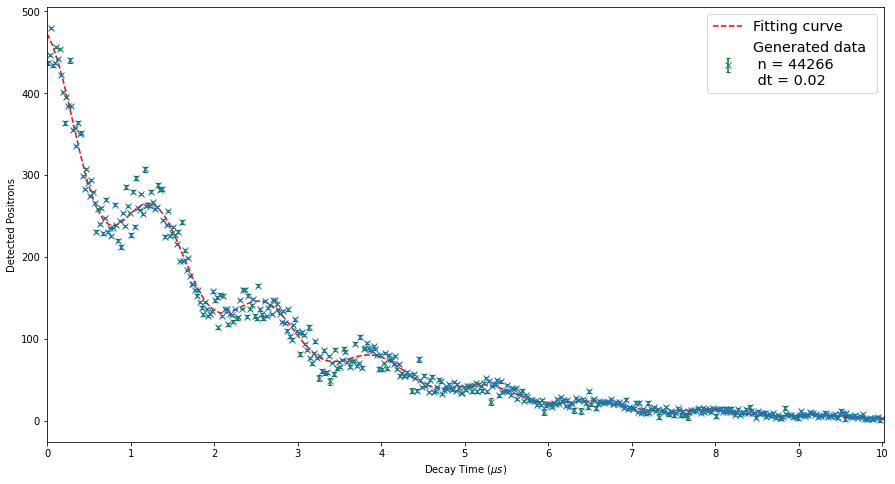

In [11]:
# Run the simulation
dt = 0.02 # time resolution 
test3 = simulator(1000000,0.0055,dt)

# Save variables appropriately and get parameters and parameter errors
test3_x64 = np.array(test3[:,1], dtype=np.float64)
test3_y64 = np.array(test3[:,0], dtype=np.float64)
count_tot3 = np.int(np.sum(test3_y64))
popt3, pcov3 = curve_fit(func, test3_x64, test3_y64, p0=[1,1,1,1,4.57,np.pi/2])
print("Parameters are", popt3)
Perr3 = np.sqrt(np.diag(pcov3))  
print("Error in parameters are", Perr3)

## Get error bars
Errors_array3 = np.zeros(np.shape(test3_x64))
for count, i in enumerate(test3_x64):
  Errors_array3[count] =  np.absolute(test3_y64[count]-func(i,*popt3))/np.sqrt(test3_y64[count])

# correct for background error in quadruature 
Errors_array3 = np.sqrt(Errors_array3**2 + Perr3[2]**2)

# Plot the original data and plot our function with our fitted parameters *popt
x_array = np.linspace(0,10,150)
plt.figure(figsize=(15,8))
plt.errorbar(test3_x64, test3_y64, yerr= Errors_array3, label = "Generated data \n n = {} \n dt = {}" .format(count_tot3, dt), ecolor='green', fmt="x", capsize=2)
#plt.yscale("log",base = 10)
plt.plot(x_array, func(x_array, *popt3), 'r--', label = "Fitting curve")
plt.legend(fontsize="x-large")

plt.xlabel(r"Decay Time ($\mu s$)")
plt.ylabel("Detected Positrons")

# Visual stuff for the plot
plt.xlim(xmin=0,xmax=10+dt); 
plt.xticks(ticks=np.linspace(0,10,11));



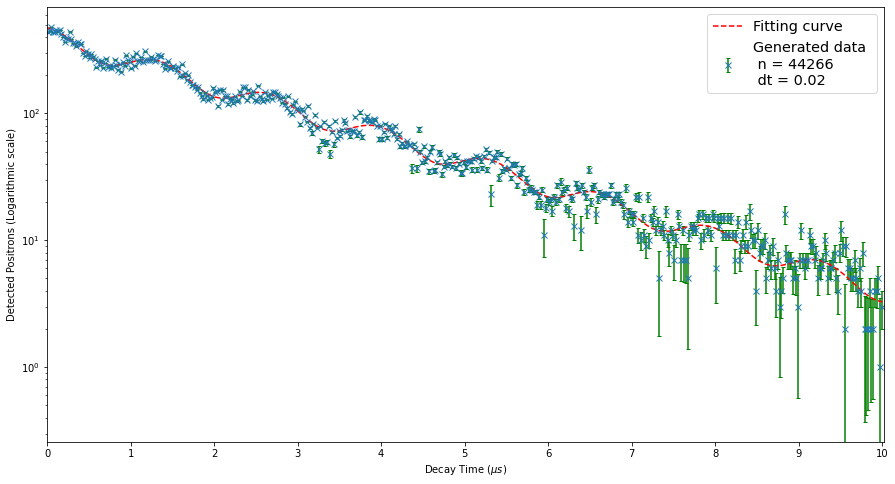

In [12]:
# Plot the original data and plot our function with our fitted parameters *popt
plt.figure(figsize=(15,8))
plt.errorbar(test3_x64, test3_y64, yerr= Errors_array3, label = "Generated data \n n = {} \n dt = {}" .format(count_tot3, dt), ecolor='green', fmt="x", capsize=2)
plt.yscale("log",base = 10)
plt.plot(x_array, func(x_array, *popt3), 'r--', label = "Fitting curve")
plt.legend(fontsize="x-large")

plt.xlabel(r"Decay Time ($\mu s$)")
plt.ylabel("Detected Positrons (Logarithmic scale)")

# Visual stuff for the plot
plt.xlim(xmin=0,xmax=10+dt) ; 
plt.xticks(ticks=np.linspace(0,10,11));


$$ \omega = 4570000 \pm 110000 \hspace{0.1cm} (Hz)   $$
$$ g = 1.94 \pm 0.08 $$

$$ \omega = 4591027.76 \pm 0.03 \hspace{0.1cm} (Hz)   $$
$$ g = 1.96 \pm 0.08 $$

$$ \omega = 3873308.84 \pm 0.02 \hspace{0.1cm} (Hz)   $$
$$ g = 1.66 \pm 0.07 $$

$$ \omega = 4270106.10 \pm 0.06 \hspace{0.1cm} (Hz)   $$
$$ g = 1.83 \pm 0.06 $$

$$ \langle  \hat{S}_x \rangle$$
$$ \langle  \hat{S}_y \rangle$$

$$ (cos{\theta})$$

In [24]:
dt = 0.2
test_x64, test_y64, count_tot, popt, pcov, Perr, Errors_array = simulator_calculate(400000, B, dt)
#plt.yscale("log",base = 10) # optionally set to log scale 

def func_old(x, a, b, c):
  """Function of the counts of different decay times"""
  return a * np.exp(-b * x) + c


Parameters are [ 1.60235254e+03  4.46973888e-01 -5.01363925e-01  2.92543213e+02
  4.76209694e+00  1.83435844e+00]
Error in parameters are [1.64865132e+01 9.82381981e-03 7.41026714e+00 1.52359678e+01
 4.72573337e-02 8.00874801e-02]


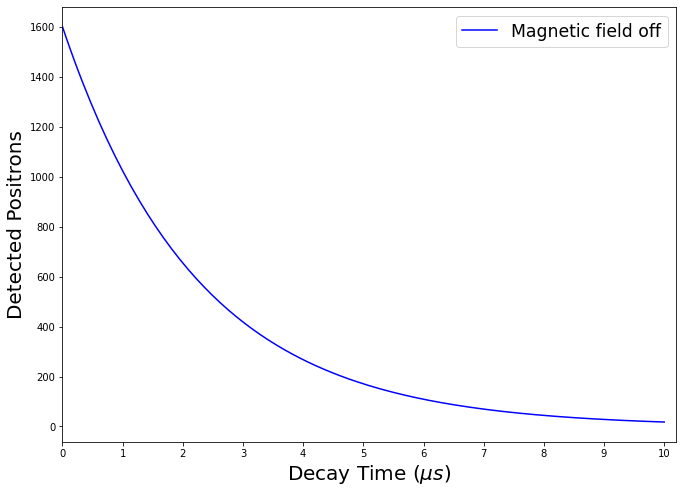

In [33]:
# Plot the original data and plot our function with our fitted parameters *popt
x_array = np.linspace(0,10,150)
plt.figure(figsize=(11,8))
#plt.errorbar(test_x64, test_y64, yerr= Errors_array, label = "Generated data \n n = {} \n dt = {}" .format(count_tot, dt), ecolor='green', fmt="x", capsize=2)
#plt.plot(x_array, func(x_array, *popt), 'r--', label = "Magnetic field on")
plt.plot(x_array, func_old(x_array, popt[0],popt[1],popt[2]), 'b-', label = "Magnetic field off")
plt.legend(fontsize="xx-large")

plt.xlabel(r"Decay Time ($\mu s$)",fontsize=20)
plt.ylabel("Detected Positrons",fontsize=20)
#plt.ylabel("Count")

# Visual stuff for the plot
plt.xlim(xmin=0,xmax=10+dt); 
plt.xticks(ticks=np.linspace(0,10,11));

#plt.yscale("log",base = 10) # optionally set to log scale 